In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
cwd = os.getcwd()

NOTEBOOK_DIR = os.path.dirname(cwd)
ROOT = os.path.dirname(os.path.dirname(os.path.dirname(NOTEBOOK_DIR)))

FIGURES_DIR = os.path.join(ROOT, 'figures/abc_parameterizations/initialization')
CONFIG_PATH = os.path.join(ROOT, 'pytorch/configs/abc_parameterizations', 'fc_ipllr_mnist.yaml')

In [3]:
import sys
sys.path.append(ROOT)

In [57]:
import os
from copy import deepcopy
import torch
import math
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, Subset, DataLoader
import torch.nn.functional as F

from utils.tools import read_yaml, set_random_seeds
from pytorch.configs.base import BaseConfig
from pytorch.configs.model import ModelConfig
from pytorch.models.abc_params.fully_connected.ipllr import FcIPLLR
from pytorch.models.abc_params.fully_connected.muP import FCmuP
from pytorch.models.abc_params.fully_connected.ntk import FCNTK
from pytorch.models.abc_params.fully_connected.standard_fc_ip import StandardFCIP
from utils.dataset.mnist import load_data
from utils.abc_params.debug_ipllr import *
from utils.plot.abc_parameterizations.ranks import *

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

### Load basic configuration and define variables 

In [6]:
N_TRIALS = 3
SEED = 30
L = 6
width = 1024
n_warmup_steps = 1
batch_size = 512
base_lr = 0.1
n_steps = 50
tol = 1.0e-8
activation = 'elu'

set_random_seeds(SEED)  # set random seed for reproducibility
config_dict = read_yaml(CONFIG_PATH)

In [7]:
config_dict = read_yaml(CONFIG_PATH)

input_size = config_dict['architecture']['input_size']

config_dict['architecture']['width'] = width
config_dict['architecture']['n_layers'] = L + 1
config_dict['optimizer']['params']['lr'] = base_lr
config_dict['activation']['name'] = activation
config_dict['scheduler'] = {'name': 'warmup_switch',
                            'params': {'n_warmup_steps': n_warmup_steps,
                                       'calibrate_base_lr': True,
                                       'default_calibration': False}}
        
base_model_config = ModelConfig(config_dict)
base_model_config.scheduler = None

### Load data & define model

In [8]:
training_dataset, test_dataset = load_data(download=False, flatten=True)
train_data_loader = DataLoader(training_dataset, shuffle=True, batch_size=batch_size)
test_batches = list(DataLoader(test_dataset, shuffle=False, batch_size=batch_size))
batches = list(train_data_loader)
eval_batch = test_batches[0]

In [9]:
full_x = torch.cat([a for a,_ in batches], dim=0)
full_y = torch.cat([b for _,b in batches], dim=0)

## Define model

In [10]:
muPs = [FCmuP(base_model_config) for _ in range(N_TRIALS)]

In [11]:
for muP in muPs:
    for i, param_group in enumerate(muP.optimizer.param_groups):
        if i == 0:
            param_group['lr'] = param_group['lr'] * (muP.d + 1)

## Save initial model

In [12]:
muPs_0 = [deepcopy(muP) for muP in muPs]

### Train model one step : t=1

In [13]:
x, y = batches[0]
muPs_1 = []
for muP in muPs:
    train_model_one_step(muP, x, y, normalize_first=True)
    muPs_1.append(deepcopy(muP))

input abs mean in training:  0.6950533986091614
loss derivatives for model: tensor([[-0.9008,  0.1022,  0.1012,  ...,  0.0996,  0.1004,  0.0995],
        [ 0.0982, -0.8990,  0.1024,  ...,  0.0987,  0.1011,  0.1017],
        [ 0.1008,  0.1014,  0.1021,  ...,  0.0976,  0.1022, -0.9015],
        ...,
        [ 0.0998,  0.1026,  0.1028,  ...,  0.0984,  0.1006, -0.9015],
        [ 0.1006,  0.1013,  0.1016,  ...,  0.0986,  0.0994,  0.0985],
        [ 0.0995,  0.1007,  0.1031,  ...,  0.0984, -0.8977,  0.0990]])
average training loss for model1 : 2.3053157329559326

input abs mean in training:  0.6950533986091614
loss derivatives for model: tensor([[-0.9000,  0.0993,  0.1001,  ...,  0.0994,  0.1000,  0.0993],
        [ 0.0993, -0.9005,  0.1004,  ...,  0.1002,  0.0979,  0.1000],
        [ 0.0978,  0.0987,  0.0999,  ...,  0.1005,  0.0994, -0.9010],
        ...,
        [ 0.0991,  0.0992,  0.1003,  ...,  0.1004,  0.0991, -0.8999],
        [ 0.0987,  0.1006,  0.0999,  ...,  0.1014,  0.0986,  0.099

### Train model for a second step : t=2

In [14]:
x, y = batches[1]
muPs_2 = []

for muP in muPs:
    train_model_one_step(muP, x, y, normalize_first=True)
    muPs_2.append(deepcopy(muP))

input abs mean in training:  0.6921874284744263
loss derivatives for model: tensor([[ 0.0930,  0.1044,  0.1000,  ...,  0.0989, -0.8943,  0.1059],
        [ 0.1001,  0.1008,  0.1060,  ...,  0.0886,  0.1036,  0.1004],
        [ 0.0988,  0.1001,  0.0963,  ...,  0.0962,  0.1053,  0.1042],
        ...,
        [ 0.1019,  0.0970,  0.0967,  ...,  0.0955,  0.1076,  0.1033],
        [ 0.0922, -0.8839,  0.1054,  ...,  0.0956,  0.1012,  0.0977],
        [ 0.0943,  0.0983,  0.1018,  ...,  0.0987, -0.8879,  0.1056]])
average training loss for model1 : 2.2250635623931885

input abs mean in training:  0.6921874284744263
loss derivatives for model: tensor([[ 0.0931,  0.1108,  0.0958,  ...,  0.1012, -0.8984,  0.1052],
        [ 0.1009,  0.1003,  0.1012,  ...,  0.0946,  0.1027,  0.0995],
        [ 0.0979,  0.1023,  0.0938,  ...,  0.0965,  0.1066,  0.1024],
        ...,
        [ 0.1010,  0.0987,  0.0964,  ...,  0.0963,  0.1081,  0.1019],
        [ 0.0927, -0.8780,  0.0993,  ...,  0.1003,  0.0961,  0.099

In [15]:
for i in range(N_TRIALS):
    muPs[i].eval()
    muPs_0[i].eval()
    muPs_1[i].eval()
    muPs_2[i].eval()

In [16]:
layer_scales = muPs[0].layer_scales
intermediate_layer_keys = ["layer_{:,}_intermediate".format(l) for l in range(2, L + 1)]

### Define W0 and b0

In [17]:
W0s = []
b0s = []
for muP_0 in muPs_0:
    W0, b0 = get_W0_dict(muP_0, normalize_first=True) 
    W0s.append(W0)
    b0s.append(b0)

### Define Delta_W_1 and Delta_b_1

In [18]:
Delta_W_1s = []
Delta_b_1s = []
for i in range(N_TRIALS):
    Delta_W_1, Delta_b_1 = get_Delta_W1_dict(muPs_0[i], muPs_1[i], normalize_first=True)
    Delta_W_1s.append(Delta_W_1)
    Delta_b_1s.append(Delta_b_1)

### Define Delta_W_2 and Delta_b_2

In [19]:
Delta_W_2s = []
Delta_b_2s = []
for i in range(N_TRIALS):
    Delta_W_2, Delta_b_2 = get_Delta_W1_dict(muPs_1[i], muPs_2[i], normalize_first=True)
    Delta_W_2s.append(Delta_W_2)
    Delta_b_2s.append(Delta_b_2)

## Explore at step 1

### On all training samples

In [20]:
x, y = full_x, full_y

In [21]:
h0s = []
delta_h_1s = []
h1s = []
x1s = []
for i in range(N_TRIALS):
    
    h0, delta_h_1, h1, x1 = get_contributions_1(x, muPs_1[i], W0s[i], b0s[i], Delta_W_1s[i], Delta_b_1s[i],
                                                normalize_first=True)
    h0s.append(h0)
    delta_h_1s.append(delta_h_1)
    h1s.append(h0)
    x1s.append(x1)

## Ranks after one step

### Rank of the initial weights and first two updates 

In [67]:
weight_ranks_dfs_dict = dict()

tol = None
weight_ranks_dfs_dict['svd_default'] = [get_svd_ranks_weights(W0s[i], Delta_W_1s[i], Delta_W_2s[i], L, tol=tol) 
                                        for i in range(N_TRIALS)]

tol = 1e-7
weight_ranks_dfs_dict['svd_tol'] = [get_svd_ranks_weights(W0s[i], Delta_W_1s[i], Delta_W_2s[i], L, tol=tol) 
                                    for i in range(N_TRIALS)]

weight_ranks_dfs_dict['squared_tr'] = [get_square_trace_ranks_weights(W0s[i], Delta_W_1s[i], Delta_W_2s[i], L) 
                                       for i in range(N_TRIALS)]

In [68]:
weight_ranks_df_dict = {key: get_concatenated_ranks_df(weight_ranks_dfs_dict[key]) 
                        for key in weight_ranks_dfs_dict.keys()}
avg_ranks_df_dict = {key: get_avg_ranks_dfs(weight_ranks_df_dict[key]) 
                     for key in weight_ranks_df_dict.keys()}

for key in weight_ranks_df_dict.keys():
    print(key)
    print(avg_ranks_df_dict[key])
    print('\n\n')

svd_default
         W0  Delta_W_1  Delta_W_2   max
layer                                  
1.0     784        450        438   784
2.0    1024        494        463  1024
3.0    1024        490        445  1024
4.0    1023        481        424  1024
5.0    1024        464        383  1024
6.0    1023        425        315  1024
7.0      10          9          9    10



svd_tol
         W0  Delta_W_1  Delta_W_2   max
layer                                  
1.0     784        538        535   784
2.0    1024        511        505  1024
3.0    1024        510        504  1024
4.0    1024        507        501  1024
5.0    1024        503        497  1024
6.0    1024        493        485  1024
7.0      10          9          9    10



squared_tr
        W0  Delta_W_1  Delta_W_2   max
layer                                 
1.0    443          5          3   784
2.0    511          5          3  1024
3.0    511          5          4  1024
4.0    511          5          4  1024
5.0    51

In [69]:
ranks_dfs = [weight_ranks_df_dict['svd_default'],
             weight_ranks_df_dict['svd_tol'],
             weight_ranks_df_dict['squared_tr']]

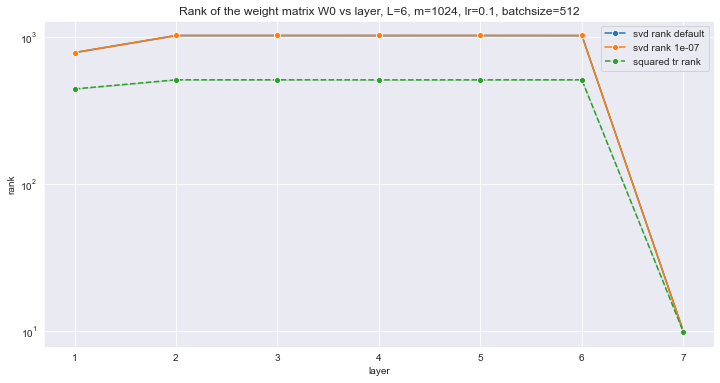

In [72]:
plt.figure(figsize=(12, 6))
plot_weights_ranks_vs_layer('W0', ranks_dfs, tol, L, width, base_lr, batch_size, y_scale='log')
plt.show()

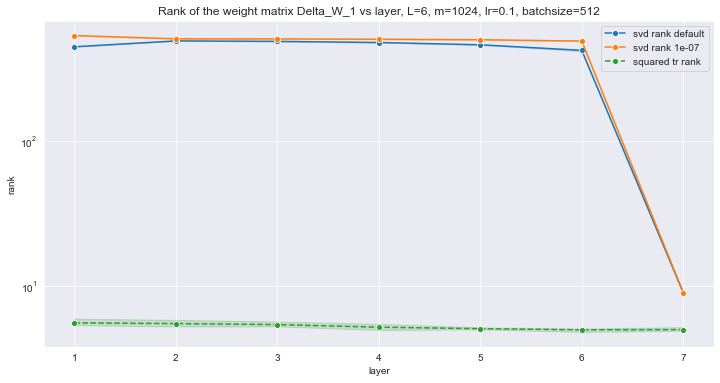

In [73]:
plt.figure(figsize=(12, 6))
plot_weights_ranks_vs_layer('Delta_W_1', ranks_dfs, tol, L, width, base_lr, batch_size, y_scale='log')
plt.show()

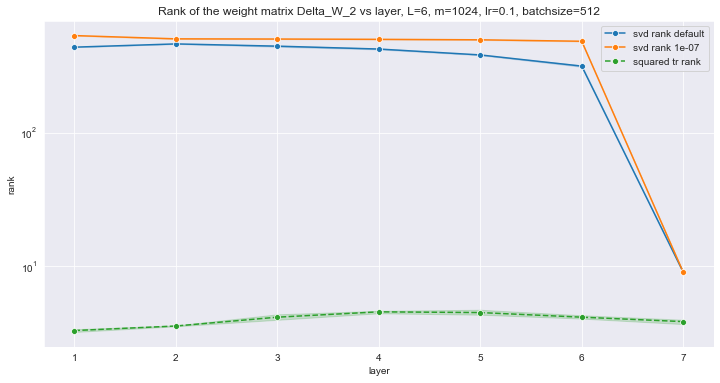

In [74]:
plt.figure(figsize=(12, 6))
plot_weights_ranks_vs_layer('Delta_W_2', ranks_dfs, tol, L, width, base_lr, batch_size, y_scale='log')
plt.show()

#### Ranks of the pre-activations

In [51]:
act_ranks_dfs_dict = dict()

tol = None
act_ranks_dfs_dict['svd_default'] = [get_svd_ranks_acts(h0s[i], delta_h_1s[i], h1s[i], x1s[i], L, tol=tol) 
                                        for i in range(N_TRIALS)]

tol = 1e-7
act_ranks_dfs_dict['svd_tol'] = [get_svd_ranks_acts(h0s[i], delta_h_1s[i], h1s[i], x1s[i], L, tol=tol) 
                                    for i in range(N_TRIALS)]

act_ranks_dfs_dict['squared_tr'] = [get_square_trace_ranks_acts(h0s[i], delta_h_1s[i], h1s[i], x1s[i], L) 
                                       for i in range(N_TRIALS)]

In [54]:
act_ranks_df_dict = {key: get_concatenated_ranks_df(act_ranks_dfs_dict[key]) 
                        for key in act_ranks_dfs_dict.keys()}
avg_ranks_df_dict = {key: get_avg_ranks_dfs(act_ranks_df_dict[key]) 
                     for key in act_ranks_df_dict.keys()}

for key in avg_ranks_df_dict.keys():
    print(key)
    print(avg_ranks_df_dict[key])
    print('\n\n')

svd_default
        h0  delta_h_1   h1   x1   max
layer                                
1.0    428         25  428  455  1024
2.0    347         19  347  411  1024
3.0    345         16  345  392  1024
4.0    337         15  337  370  1024
5.0    322         13  322  356  1024
6.0    314         12  314  340  1024
7.0     10          9   10   10    10



svd_tol
         h0  delta_h_1    h1    x1   max
layer                                   
1.0    1024       1024  1024  1024  1024
2.0    1024        975  1024  1024  1024
3.0    1024        959  1024  1024  1024
4.0    1024        936  1024  1024  1024
5.0    1024        908  1024  1024  1024
6.0    1024        870  1024  1024  1024
7.0      10          9    10    10    10



squared_tr
       h0  delta_h_1  h1  x1   max
layer                             
1.0     8          2   8   4  1024
2.0     3          2   3   3  1024
3.0     3          1   3   3  1024
4.0     3          1   3   3  1024
5.0     3          1   3   3  1024
6.0    

In [59]:
ranks_dfs = [act_ranks_df_dict['svd_default'],
             act_ranks_df_dict['svd_tol'],
             act_ranks_df_dict['squared_tr']]

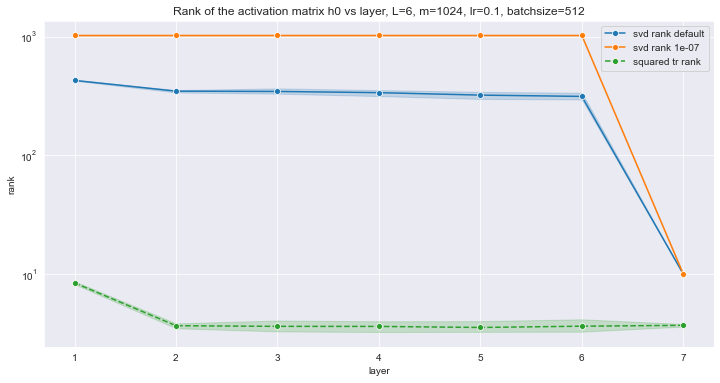

In [63]:
plt.figure(figsize=(12, 6))
plot_acts_ranks_vs_layer('h0', ranks_dfs, tol, L, width, base_lr, batch_size, y_scale='log')
plt.show()

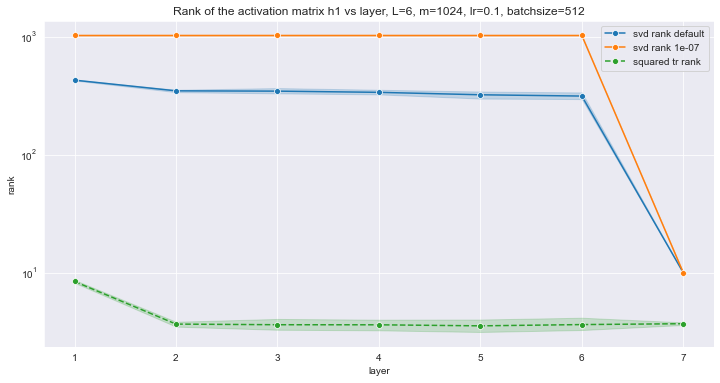

In [64]:
plt.figure(figsize=(12, 6))
plot_acts_ranks_vs_layer('h1', ranks_dfs, tol, L, width, base_lr, batch_size, y_scale='log')
plt.show()

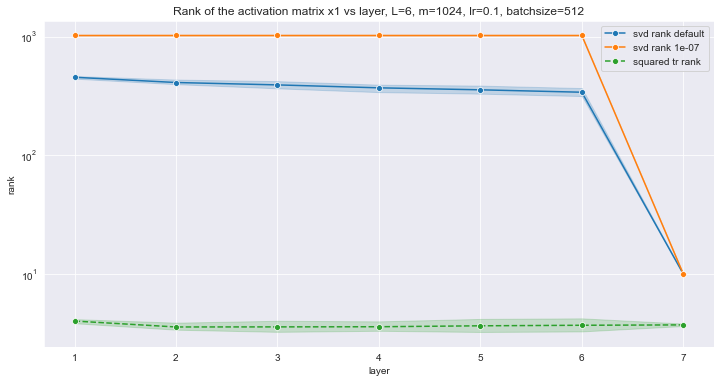

In [66]:
plt.figure(figsize=(12, 6))
plot_acts_ranks_vs_layer('x1', ranks_dfs, tol, L, width, base_lr, batch_size, y_scale='log')
plt.show()

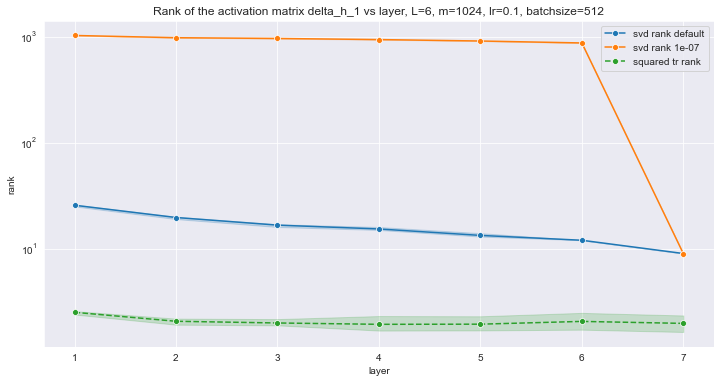

In [65]:
plt.figure(figsize=(12, 6))
plot_acts_ranks_vs_layer('delta_h_1', ranks_dfs, tol, L, width, base_lr, batch_size, y_scale='log')
plt.show()

### Diversity in terms of position of the maximum index

In [92]:
max_acts_diversity_dfs = [get_max_acts_diversity(h0s[i], delta_h_1s[i], h1s[i], L) for i in range(N_TRIALS)]

In [93]:
max_acts_diversity_df = get_concatenated_ranks_df(max_acts_diversity_dfs)

In [94]:
avg_max_acts_diversity_df = get_avg_ranks_dfs(max_acts_diversity_df)
avg_max_acts_diversity_df

,h0,delta_h_1,h1,max
layer,,,,
1.0,709,87,709,60000
2.0,332,65,332,60000
3.0,316,61,316,60000
4.0,294,53,294,60000
5.0,306,74,306,60000
6.0,298,88,298,60000
7.0,10,9,10,60000
